# Homework 9: Conway's Game of Life 
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [The Game of Life sequentially](#The-Game-of-Life-sequentially)
* [The Game of Life parallel](#The-Game-of-Life-parallel)
* [Gosper's glider gun](#Gosper's-glider-gun)
* [Number of the living cells vs time](#Number-of-the-living-cells-vs-time)

In [1]:
#import needed libraries
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import os
from PIL import Image
import random
import time
import tracemalloc

## The Game of Life sequentially

In [76]:
def initialize(pixels):
    indices = [[1, 1],
            [2, 2], [2, 25],
            [3, 13], [3, 14], [3, 21], [3, 22], [3, 35], [3, 36],
            [4, 12], [4, 16], [4, 21], [4, 22], [4, 35], [4, 36],
            [5, 1], [5, 2], [5, 11], [5, 17], [5, 21], [5, 22],
            [6, 1], [6, 2], [6, 11], [6, 17], [6, 18], [6, 23],
            [7, 11], [7, 17], [7, 25],
            [8, 12], [8, 16],
            [9, 13], [9, 14]]
    
    for i in indices:
        pixels[i[0]][i[1]] = 1

    return pixels

In [77]:
def game_of_life(pixels, steps_limit = 100, filename='life'):
    step = 0
    number_of_alive = []
    height = pixels.shape[0]
    width = pixels.shape[1]
    while sum(sum(pixels)) != 0 and step != steps_limit:
        new_pixels = pixels.copy()
        for i in range(height):
            for j in range(width):
                total = int((pixels[i, (j-1) % width] + pixels[i, (j+1) % width] +
                             pixels[(i-1) % height, j] + pixels[(i+1) % height, j] +
                             pixels[(i-1) % height, (j-1) % width] + pixels[(i-1) % height, (j+1) % width] +
                             pixels[(i+1) % height, (j-1) % width] + pixels[(i+1) % height, (j+1) % width]))
 
                if pixels[i, j] == 1:
                    if (total < 2) or (total > 3):
                        new_pixels[i, j] = 0
                else:
                    if total == 3:
                        new_pixels[i, j] = 1
        
        number_of_alive.append(sum(sum(pixels)))
        pixels = new_pixels
        if filename is not None:
            plt.imshow(pixels, cmap='gray')
            plt.savefig('map_' + '{0:08}'.format(step) + '.png')
        print(f"survived for {step+1}", end="\r")
        step+=1

    fp_in = "map_*.png"
    
    if filename is not None:
        fp_out = f"{filename}.gif"
        img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)
    
    for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    if filename is not None:
        print(f"Animation saved in file {fp_out}")
    return number_of_alive

Animation saved in file life.gif


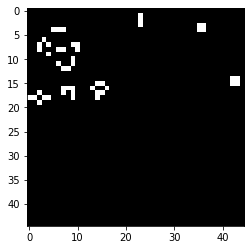

In [79]:
pixels = np.zeros([45, 45])

initialize(pixels)
_ = game_of_life(pixels)

In [93]:
a = np.array([1, 2, 3])
b = np.zeros([3, 3])
c = np.array([4, 5, 6])
b = np.concatenate((np.array([a]).T, b), axis=1)
np.concatenate((b, np.array([c]).T), axis=1)

array([[1., 0., 0., 0., 4.],
       [2., 0., 0., 0., 5.],
       [3., 0., 0., 0., 6.]])

## The Game of Life parallel

In [101]:
%%writefile life.py
# Create file life.py
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

def initialize(pixels):
    indices = [[1, 1],
            [2, 2], [2, 25],
            [3, 13], [3, 14], [3, 21], [3, 22], [3, 35], [3, 36],
            [4, 12], [4, 16], [4, 21], [4, 22], [4, 35], [4, 36],
            [5, 1], [5, 2], [5, 11], [5, 17], [5, 21], [5, 22],
            [6, 1], [6, 2], [6, 11], [6, 17], [6, 18], [6, 23],
            [7, 11], [7, 17], [7, 25],
            [8, 12], [8, 16],
            [9, 13], [9, 14]]
    
    for i in indices:
        pixels[i[0]][i[1]] = 1

    return pixels

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

pixels = np.zeros([45, 45])
initialize(pixels)

chunk_size = 45//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > 45:
    chunk_tail = 45

pixels_cur = pixels[:,chunk_head:chunk_tail]
step = 0
height = pixels_cur.shape[0]
width = pixels_cur.shape[1]

if size != 1:
        it_to_sendr = rank+1 if rank != size-1 else 0
        it_to_sendl = rank-1 if rank != 0 else size-1
        comm.send(pixels_cur[:,0], dest=it_to_sendl)
        comm.send(pixels_cur[:,width-1], dest=it_to_sendr)
        left_ghost = comm.recv(source=it_to_sendl)
        right_ghost = comm.recv(source=it_to_sendr)
        pixels_cur = np.concatenate((np.array([left_ghost]).T, pixels_cur), axis=1)
        pixels_cur = np.concatenate((pixels_cur, np.array([right_ghost]).T), axis=1)

height = pixels_cur.shape[0]
width = pixels_cur.shape[1]
        
step = 0
while sum(sum(pixels_cur)) != 0 and step != 100:
    new_pixels = pixels_cur.copy()
    for i in range(height):
        for j in range(width):
            total = int((pixels[i, (j-1) % width] + pixels[i, (j+1) % width] +
                             pixels[(i-1) % height, j] + pixels[(i+1) % height, j] +
                             pixels[(i-1) % height, (j-1) % width] + pixels[(i-1) % height, (j+1) % width] +
                             pixels[(i+1) % height, (j-1) % width] + pixels[(i+1) % height, (j+1) % width]))
 
            if pixels[i, j] == 1:
                if (total < 2) or (total > 3):
                    new_pixels[i, j] = 0
            else:
                if total == 3:
                    new_pixels[i, j] = 1
    pixels_cur = new_pixels
    step += 1
    if rank == 0:
        print(f"step {step}", end='\r')

Overwriting life.py


In [102]:
!mpirun --allow-run-as-root -np 2 python3 life.py

## Gosper's glider gun

Animation saved in file gilder_gun.gif


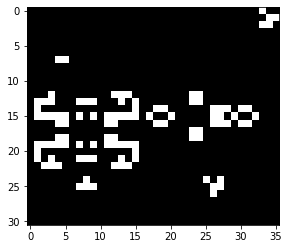

In [62]:
glider_gun =\
np.array([
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

_ = game_of_life(glider_gun, 100, 'gilder_gun')

## Number of the living cells vs time

Text(0.5, 1.0, 'Evolution of cells')

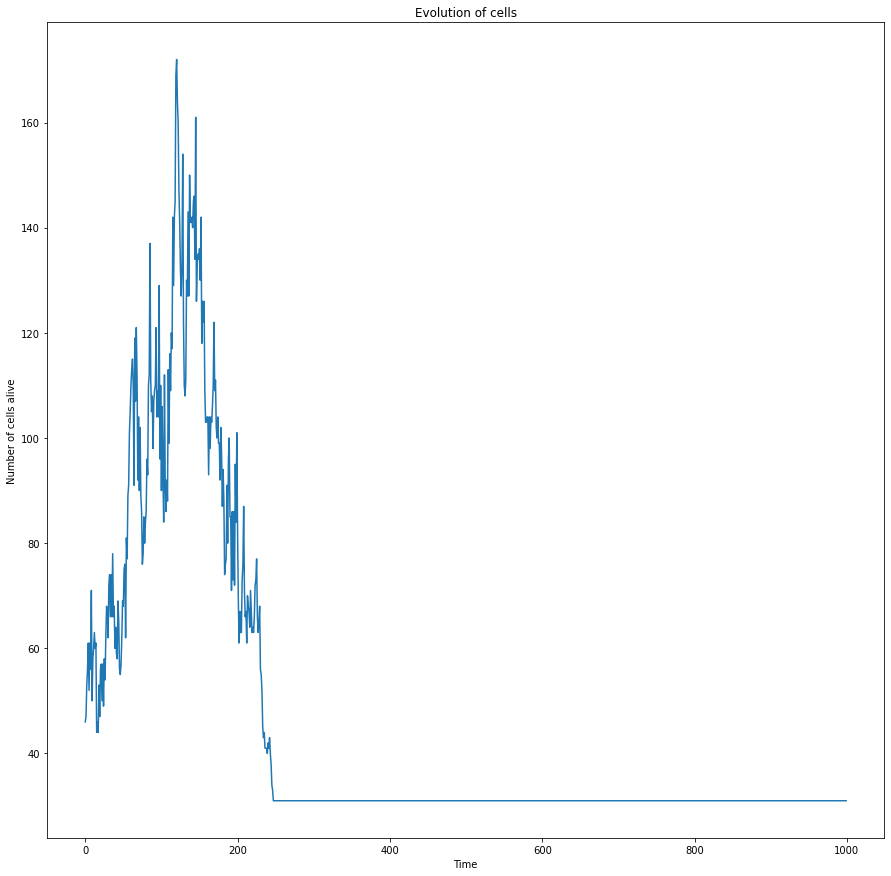

In [74]:
glider_gun_with_two_conditions =\
np.array([
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

alife = game_of_life(glider_gun_with_two_conditions, 1000, None)
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(alife)
plt.ylabel('Number of cells alive')
plt.xlabel('Time')
plt.title('Evolution of cells')